# GOPH699.50: Practice 1
# Introduction to Machine Learning

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/dtrad/geoml_course/blob/master/Practice1_IntroToML.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Summary
This first lab is just to have a feeling of the difference between machine learning and traditional data modeling.\
We will look at a regression problem. There is a data set that contains Gross Domestic Product (GDP) per capita and another that contains life satisfaction index. \
We will combine them both into a data set (X,y) and try to fit models to it, first with simple regresion, and then machine learning, using two approaches
* Linear Regression
* Neural networks


## Loading modules and data
We will always start all notebooks reading some modules with useful libraries and functions that we will need.\
Then we will load the data using pandas and manipulate them using numpy and scikit-learn

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model

In [14]:
import os
datapath = os.path.join("datasets", "lifesat", "")
# Download the data
import urllib.request
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
os.makedirs(datapath, exist_ok=True)
for filename in ("oecd_bli_2015.csv", "gdp_per_capita.csv"):
    print("Downloading", filename)
    url = DOWNLOAD_ROOT + "datasets/lifesat/" + filename
    urllib.request.urlretrieve(url, datapath + filename)

In [15]:
!ls -alt datasets/lifesat

total 432
-rw-rw-r--. 1 dtrad dtrad  36323 Sep  7 08:01 gdp_per_capita.csv
-rw-rw-r--. 1 dtrad dtrad 405467 Sep  7 08:01 oecd_bli_2015.csv
drwxrwxr-x. 2 dtrad dtrad     67 Sep  2  2020 .
drwxrwxr-x. 3 dtrad dtrad     28 Sep  2  2020 ..


In [17]:
#!head datasets/lifesat/gdp_per_capita.csv

In [18]:
# Load the data using panda reader. We will see pandas in Lecture 4
oecd_bli = pd.read_csv(datapath + "oecd_bli_2015.csv", thousands=',')
gdp_per_capita = pd.read_csv(datapath + "gdp_per_capita.csv",thousands=',',delimiter='\t',encoding='latin1', na_values="n/a")

In [20]:
print(type(oecd_bli),type(gdp_per_capita))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [21]:
oecd_bli.head()

,LOCATION,Country,INDICATOR,Indicator,MEASURE,Measure,INEQUALITY,Inequality,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,AUS,Australia,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,1.1,E,Estimated value
1,AUT,Austria,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,1.0,NaN,NaN
2,BEL,Belgium,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,2.0,NaN,NaN
3,CAN,Canada,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,0.2,NaN,NaN
4,CZE,Czech Republic,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,0.9,NaN,NaN


In [22]:
gdp_per_capita.head()

,Country,Subject Descriptor,Units,Scale,Country/Series-specific Notes,2015,Estimates Start After
0,Afghanistan,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",599.994,2013.0
1,Albania,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",3995.383,2010.0
2,Algeria,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4318.135,2014.0
3,Angola,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4100.315,2014.0
4,Antigua and Barbuda,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",14414.302,2011.0


The following function merges the OECD's life satisfaction data and the IMF's GDP per capita data. It is not quite important at this point of the course but
will discuss this later in lecture 8.

In [23]:
def prepare_country_stats(oecd_bli, gdp_per_capita):
    oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
    oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
    gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
    gdp_per_capita.set_index("Country", inplace=True)
    full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita,
                                  left_index=True, right_index=True)
    full_country_stats.sort_values(by="GDP per capita", inplace=True)
    remove_indices = [0, 1, 6, 8, 33, 34, 35]
    #remove_indices = []
    keep_indices = list(set(range(36)) - set(remove_indices))
    return full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices]

In [24]:
# Prepare the data
country_stats = prepare_country_stats(oecd_bli, gdp_per_capita)
# We read a panda dataframe and access its columns (features) by column name.
# These objects are called Series (part of Pandas)
# Then convert them to numpy arrays (Lecture 4)

X = np.c_[country_stats["GDP per capita"]]
y = np.c_[country_stats["Life satisfaction"]]

In [25]:
print(type(country_stats),type(X),type(y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [26]:
country_stats.head()

,GDP per capita,Life satisfaction
Country,,
Russia,9054.914,6.0
Turkey,9437.372,5.6
Hungary,12239.894,4.9
Poland,12495.334,5.8
Slovak Republic,15991.736,6.1


In [30]:
# Each numpy array in this case is a column vector. Very often we will be using matrices for X and vectors for y.
print(X.shape, y.shape)

(29, 1) (29, 1)


In [31]:
[print(X[i],y[i]) for i in np.arange(len(y)) ]
print()

[9054.914] [6.]
[9437.372] [5.6]
[12239.894] [4.9]
[12495.334] [5.8]
[15991.736] [6.1]
[17288.083] [5.6]
[18064.288] [4.8]
[19121.592] [5.1]
[20732.482] [5.7]
[25864.721] [6.5]
[27195.197] [5.8]
[29866.581] [6.]
[32485.545] [5.9]
[35343.336] [7.4]
[37044.891] [7.3]
[37675.006] [6.5]
[40106.632] [6.9]
[40996.511] [7.]
[41973.988] [7.4]
[43331.961] [7.3]
[43603.115] [7.3]
[43724.031] [6.9]
[43770.688] [6.8]
[49866.266] [7.2]
[50854.583] [7.5]
[50961.865] [7.3]
[51350.744] [7.]
[52114.165] [7.5]
[55805.204] [7.2]



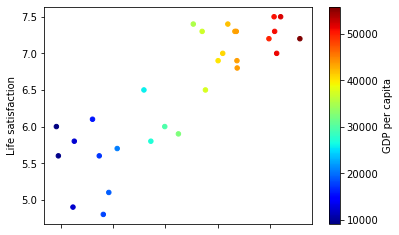

In [32]:
# We can plot using Pandas directly, which actually calls Matplotlib. This is the most common plotting library we will use in Python, but there are others
country_stats.plot(kind='scatter',x="GDP per capita", y='Life satisfaction',c="GDP per capita",cmap='jet')

We have two variables. Are they related? \
We see both increase simultaneously, but exactly how they are related is unknown at this point.

## The classical approach
Let us try first a simple linear model. \
We will use scikit learn in large part of the course. This is the most popular library for machine learning.\
However, this first attempt will be using classical concepts, which are also implemented in Scikit-learn

In [33]:
# Select a linear model
model = sklearn.linear_model.LinearRegression()

In [36]:
# model is a python class from the LinearRegression type. It has many methods.Uncomment the next line to learn about it.
model?

Type:        LinearRegression
String form: LinearRegression()
File:        ~/anaconda3/envs/tfgpu3/lib/python3.8/site-packages/sklearn/linear_model/_base.py
Docstring:  
Ordinary least squares Linear Regression.

LinearRegression fits a linear model with coefficients w = (w1, ..., wp)
to minimize the residual sum of squares between the observed targets in
the dataset, and the targets predicted by the linear approximation.

Parameters
----------
fit_intercept : bool, default=True
    Whether to calculate the intercept for this model. If set
    to False, no intercept will be used in calculations
    (i.e. data is expected to be centered).

normalize : bool, default=False
    This parameter is ignored when ``fit_intercept`` is set to False.
    If True, the regressors X will be normalized before regression by
    subtracting the mean and dividing by the l2-norm.
    If you wish to standardize, please use
    :class:`~sklearn.preprocessing.StandardScaler` before calling ``fit``
    on an 

In [35]:
# Sklearn classes usually have the same type of functions: fit, transform, predict.
# For training the model, we will use "fit". We say "train" but in reality we are just doing data fitting by solving a system of equations.
model.fit(X, y)

LinearRegression()

In [37]:
# That is it, we have a model. How do we know it worked? We have to compare predictions with observations
X_new=np.linspace(10000,50000,100)

In [38]:
print(X_new.shape)

(100,)


In [43]:
# Sklearn usually needs the input with a second index
X_new.reshape(-1,1).shape

(100, 1)

In [44]:
# Again, sklearn makes it easy for us by always using the same names for functions.
y_new=model.predict(X_new.reshape(-1,1))

([<matplotlib.lines.Line2D at 0x7f0f0bec8070>,
 Text(0.5, 0, 'GDP'),
 Text(0, 0.5, 'life satisfaction'),
 Text(0.5, 1.0, 'linear model'))

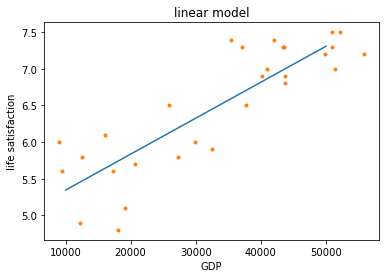

In [45]:
# Now we plot with Matplotlib directly (Lecture 5)
plt.plot(X_new,y_new,X,y,'.'),plt.xlabel('GDP'),plt.ylabel('life satisfaction'),plt.title('linear model')

The general trends seems right. There is significant dispersion which may be noise, or maybe our model is just too simple.\
Let us try a high order polynomial. We will also use a scaler to make fitting easier (high order powers of the independent variable may blow up without pre-scaling)

In [47]:
# In addition we need a preprocessing tool and, just to make it interesting, a dataflow (pipeline) that we can repeat later.
from sklearn import preprocessing
from sklearn import pipeline

In [48]:
# First, let us get all the pieces we need (the modules of the dataflow)
poly = preprocessing.PolynomialFeatures(degree=10, include_bias=False)
scaler = preprocessing.StandardScaler()
lin_reg2 = sklearn.linear_model.LinearRegression()

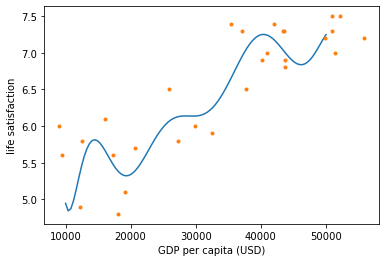

In [49]:
# Here is the beauty of pipelines. We just add the modules and call our old friends, fit and predict.
pipeline_reg = pipeline.Pipeline([('poly', poly), ('scal', scaler), ('lin', lin_reg2)])
pipeline_reg.fit(X, y)
curve = pipeline_reg.predict(X_new.reshape(-1,1))
plt.plot(X_new, curve, X, y, '.')
plt.xlabel("GDP per capita (USD)"),
plt.ylabel("life satisfaction")
plt.show()

This was easy! That is thanks to Sklearn developers who did all the work to encapsulate methods using Object Oriented Programming (OOP) \
We will discuss OOP in Lecture 2. 

Now, going back to the math. What we did above is not really machine learning since we specify the polynomial order. We just did regression.\
We told the program the rules and just used the algorithm to adjust the parameters (coefficients) that control the model.\
To do machine learning we have to let the program to define the rules, although of course with some guidance.

## The machine Learning approach with Neural Networks
Although there are many different ML algorithms we could use for this problem, Neural Networks have a strong "create the rules" feeling.\
Other ML algorithms sometimes are also defining the rules, sometimes are applying algorithms similar to classical techniques.\
It does not mean the NN are always better, but in this practice we want to make a clear distinction between traditional and ML approaches.

Let us use tensorflow and from tensorflow an application programmer interface (API) called Keras. \
This is another ML library we will use in much of the course when we get into Deep Learning.

In [50]:
# We import tensorflow.keras, which is an Application Programmer Interface (API)
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

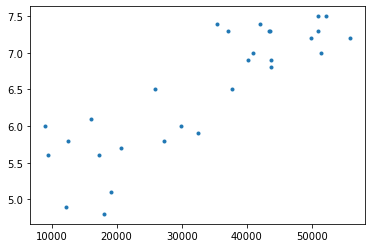

In [51]:
# Again, let us plot the data to remind ourselves what we are doing
plt.plot(X,y,'.')

This is going to be a real Machine Learning approach because the information will come directly from the data.\
We will create a general network, that is the architecture to solve the problem. \
This network is going to be very general, we could use for many different problems. \
Notice, the architecture of the network is not based on any particular understanding of problem (sometimes, we will need to be more careful)

In [53]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
Xs=scaler.fit_transform(X)
model = keras.models.Sequential()
model.add(keras.Input(shape=(Xs.shape[1:])))
model.add(keras.layers.Dense(30,activation="relu"))
model.add(keras.layers.Dense(30,activation="tanh"))
model.add(keras.layers.Dense(1,activation="linear"))

The network is graph. Graphs are mathematical constructs to solve problems by finding relationships between nodes through edges.\
For the graph to work, we need to compile first. This converts our instructions above into something that the machine understands.\
Also, compilation nees to be more specific about certain things we didn't explain before. How are we solving the optimization?

In [54]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-1))

In [55]:
model.fit(Xs,y,epochs=20)

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 43.7146
Epoch 2/20
1/1 [==============================] - 0s 4ms/step - loss: 3.6404
Epoch 3/20
1/1 [==============================] - 0s 4ms/step - loss: 4.3396
Epoch 4/20
1/1 [==============================] - 0s 4ms/step - loss: 9.0726
Epoch 5/20
1/1 [==============================] - 0s 4ms/step - loss: 4.2197
Epoch 6/20
1/1 [==============================] - 0s 4ms/step - loss: 6.5404
Epoch 7/20
1/1 [==============================] - 0s 5ms/step - loss: 1.7817
Epoch 8/20
1/1 [==============================] - 0s 4ms/step - loss: 1.9152
Epoch 9/20
1/1 [==============================] - 0s 4ms/step - loss: 0.9204
Epoch 10/20
1/1 [==============================] - 0s 4ms/step - loss: 0.8436
Epoch 11/20
1/1 [==============================] - 0s 3ms/step - loss: 0.5062
Epoch 12/20
1/1 [==============================] - 0s 3ms/step - loss: 0.4370
Epoch 13/20
1/1 [==============================] - 0s 3ms/step - loss: 0.

How do we know the model that the network has captured from the data is correct? \
Just as before, we need to compare the predictions with the observations.\
This part is just the same as with the linear regressor, except that we need to apply the same scale to the input.

In [56]:
nx=len(X)
X_new=np.linspace(min(X),max(X),nx)
X_news = scaler.transform(X_new)
y_new=model.predict(X_news)

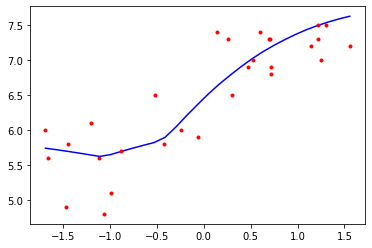

In [57]:
plt.plot(X_news,y_new,'b-')
plt.plot(Xs,y,'r.')

In [58]:
[print(y_new[i], y[i]) for i in np.arange(10)]
print()

[5.7417545] [6.]
[5.720626] [5.6]
[5.697801] [4.9]
[5.673694] [5.8]
[5.648828] [6.1]
[5.623443] [5.6]
[5.6504006] [4.8]
[5.696339] [5.1]
[5.7403913] [5.7]
[5.7825108] [6.5]



## Grouping Data

You may ask, why are we input and output one sample at a time? \
In this case, each sample is one value but in other applications we will use many.\
For example in convolutional neural networks, each input will be an array.\
But just for the experiment, let us see what happens if we use input and output all samples simultaneously. \
It does not work well but it goes something like this (play with some parameters to see if you can get it to work better)

In [59]:
model = keras.models.Sequential()
model.add(keras.Input(shape=(nx,)))
model.add(keras.layers.Dense(nx,activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(nx,activation="tanh"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(nx,activation="linear"))

Here, instead of input one sample at a time as before (X.shape[1:])=(1,) we are inputing (29,) (all samples at the same time).
Then, we made all the layers with nx neurons, but that does not matter and can be changed. Give a try.
Finally, we output all the samples at the same time instead of one at a time. 

In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 29)                870       
_________________________________________________________________
batch_normalization (BatchNo (None, 29)                116       
_________________________________________________________________
dense_4 (Dense)              (None, 29)                870       
_________________________________________________________________
dropout (Dropout)            (None, 29)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 29)                870       
Total params: 2,726
Trainable params: 2,668
Non-trainable params: 58
_________________________________________________________________


In [61]:
model.compile(loss='mse',optimizer=keras.optimizers.SGD(lr=1e-1))

In [64]:
Xs.reshape(1,-1).shape

(1, 29)

In [65]:
model.fit(Xs.reshape(1,-1),y.reshape(1,-1),epochs=20)


Epoch 1/20
1/1 [==============================] - 1s 607ms/step - loss: 42.8410
Epoch 2/20
1/1 [==============================] - 0s 5ms/step - loss: 40.5341
Epoch 3/20
1/1 [==============================] - 0s 4ms/step - loss: 36.8052
Epoch 4/20
1/1 [==============================] - 0s 4ms/step - loss: 39.4857
Epoch 5/20
1/1 [==============================] - 0s 4ms/step - loss: 32.1854
Epoch 6/20
1/1 [==============================] - 0s 4ms/step - loss: 27.7284
Epoch 7/20
1/1 [==============================] - 0s 5ms/step - loss: 30.4139
Epoch 8/20
1/1 [==============================] - 0s 4ms/step - loss: 20.7580
Epoch 9/20
1/1 [==============================] - 0s 4ms/step - loss: 15.0381
Epoch 10/20
1/1 [==============================] - 0s 5ms/step - loss: 10.8122
Epoch 11/20
1/1 [==============================] - 0s 4ms/step - loss: 4.4031
Epoch 12/20
1/1 [==============================] - 0s 3ms/step - loss: 14.1281
Epoch 13/20
1/1 [==============================] - 0s 4ms/st

In [66]:
y_new=model.predict(X_news.reshape(1,-1))

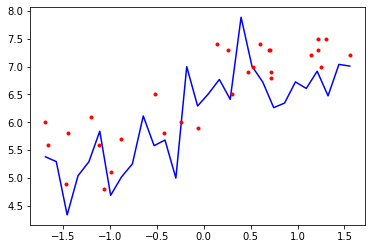

In [67]:
plt.plot(X_news.reshape(nx,1),y_new.reshape(nx,1),'b-')
plt.plot(Xs,y,'r.')

In [68]:
y=y.reshape(len(y))
[print('predicted {:.1f}'.format(y_new[0,i]), '-->true {:.1f}'.format(y[i])) for i in np.arange(10)]
print()

predicted 5.4 -->true 6.0
predicted 5.3 -->true 5.6
predicted 4.3 -->true 4.9
predicted 5.0 -->true 5.8
predicted 5.3 -->true 6.1
predicted 5.8 -->true 5.6
predicted 4.7 -->true 4.8
predicted 5.0 -->true 5.1
predicted 5.3 -->true 5.7
predicted 6.1 -->true 6.5



## Conclusion
In this practice we took a first look at the difference between Machine Learning and classical approaches. \
We tried to create models using simple concepts, without knowing exactly how or what the differences are. \
In the rest of this course we will learn the hows and whys. 
